In [258]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pysal as ps
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
%matplotlib inline
%config IPCompleter.greedy=True

In [259]:
df = pd.read_csv('fent_county_year.txt', sep = '\t')
fent_all_years = pd.read_csv('all_fentanyl_by_county.txt', sep = '\t')
fent_13_17 = pd.read_csv('all_fent_by_county_13-17.txt', sep = '\t')
national_fent = pd.read_csv('national_fent.txt', sep = '\t')
national_all_opioids = pd.read_csv('grouped_by_year_not_county_all_opioids.txt', sep = '\t')
national_fent_cocaine = pd.read_csv('fent_and_cocaine.txt', sep = '\t')
fent_by_state = pd.read_csv('fent_state.txt', sep = '\t')

In [260]:
df = df.drop('Notes', axis = 'columns')
df = df.dropna()
df = df.drop('Year Code', axis = 'columns')
df.columns = ['county', 'county_code', 'year', 'deaths', 'population', 'crude_rate', 'aa_rate']

fent_all_years = fent_all_years.drop('Notes', axis = 'columns')
fent_all_years = fent_all_years.dropna()
fent_all_years.columns = ['county', 'county_code', 'deaths', 'population', 'crude_rate', 'aa_rate']

fent_13_17 = fent_13_17.drop('Notes', axis = 'columns')
fent_13_17 = fent_13_17.dropna()
fent_13_17.columns = ['county', 'county_code', 'deaths', 'population', 'crude_rate', 'aa_rate']

national_fent = national_fent.drop('Notes', axis = 'columns')
national_fent = national_fent.dropna()
national_fent = national_fent.drop('Year Code', axis = 'columns')
national_fent.columns = ['year', 'deaths', 'population', 'crude_rate', 'aa_rate']

national_all_opioids = national_all_opioids.drop('Notes', axis = 'columns')
national_all_opioids = national_all_opioids.dropna()
national_all_opioids = national_all_opioids.drop('Year Code', axis = 'columns')
national_all_opioids.columns = ['year', 'deaths', 'population', 'crude_rate']

national_fent_cocaine = national_fent_cocaine.drop('Notes', axis = 'columns')
national_fent_cocaine = national_fent_cocaine.dropna()
national_fent_cocaine = national_fent_cocaine.drop('Year Code', axis = 'columns')
national_fent_cocaine.columns = ['year', 'deaths', 'population', 'crude_rate', 'aa_rate']

fent_by_state = fent_by_state.drop(['Notes', 'Year Code'], axis = 'columns')
fent_by_state = fent_by_state.dropna()
fent_by_state.columns = ['state', 'state_code', 'year', 'deaths', 'population', 'crude_rate', 'aa_rate']

In [261]:
# dropping hawaii and alaska because they make the map ugly
df['state'] = df.county.apply(lambda x: x[-2:])
df = df[df['state'] != 'AK']
df = df[df['state'] != 'HI']
fent_13_17['state'] = fent_13_17['county'].apply(lambda x: x[-2:])
fent_13_17 = fent_13_17[fent_13_17['state'] != 'AK']
fent_13_17 = fent_13_17[fent_13_17['state'] != 'HI']
fent_by_state_13on = fent_by_state[fent_by_state.year > 2012]
fent_by_state_13on = fent_by_state_13on[fent_by_state_13on.state != 'Alaska']
fent_by_state_13on = fent_by_state_13on[fent_by_state_13on.state != 'Hawaii']

In [262]:
df = df.drop(df[df['deaths'] == 'Missing'].index)

In [263]:
df = df.drop(df[df.county == 'Bedford city, VA'].index)

In [264]:
# for now put suppressed entries to 0
def convert_suppressed(entry):
    if entry == 'Suppressed':
        return 0
    elif entry == 'Missing':
        return 0
    else:
        return int(entry)
    
df['deaths'] = df['deaths'].apply(convert_suppressed)
fent_all_years['deaths'] = fent_all_years['deaths'].apply(convert_suppressed)
fent_13_17['deaths'] = fent_13_17['deaths'].apply(convert_suppressed)
national_fent['deaths'] = national_fent['deaths'].apply(convert_suppressed)
national_all_opioids['deaths'] = national_all_opioids['deaths'].apply(convert_suppressed)
national_fent_cocaine['deaths'] = national_fent_cocaine['deaths'].apply(convert_suppressed)
fent_by_state['deaths'] = fent_by_state['deaths'].apply(convert_suppressed)

In [267]:
hdf = df[df.year == 2017][['county', 'county_code', 'state']]
hdf['deaths13'] = list(df[df.year == 2013].deaths)
hdf['deaths14'] = list(df[df.year == 2014].deaths)
hdf['deaths15'] = list(df[df.year == 2015].deaths)
hdf['deaths16'] = list(df[df.year == 2016].deaths)
hdf['deaths17'] = list(df[df.year == 2017].deaths)
hdf['pop13'] = list(df[df.year == 2013].population)
hdf['pop14'] = list(df[df.year == 2014].population)
hdf['pop15'] = list(df[df.year == 2015].population)
hdf['pop16'] = list(df[df.year == 2016].population)
hdf['pop17'] = list(df[df.year == 2017].population)
hdf.reset_index(drop = True, inplace = True)
geodf = hdf.copy()

In [268]:
def clean_df(df):
    df = df.drop(['Notes'], axis = 'columns')
    df = df.dropna()
    df.columns = ['county', 'county_code', 'deaths', 'population', 'crude_rate']
    df.deaths = df.deaths.apply(convert_suppressed)
    return df
df_no_13 = clean_df(pd.read_csv('fent_county_14_17.txt', sep = '\t'))
df_no_14 = clean_df(pd.read_csv('fent_13151617.txt', sep = '\t'))
df_no_15 = clean_df(pd.read_csv('fent_13141617.txt', sep = '\t'))
df_no_16 = clean_df(pd.read_csv('fent_13141517.txt', sep = '\t'))
df_no_17 = clean_df(pd.read_csv('fent_13141516.txt', sep = '\t'))

In [269]:
hdf['total_deaths'] = hdf.merge(fent_13_17[['county', 'deaths']], on = 'county', how = 'left').deaths
hdf['deaths_no_13'] = hdf.merge(df_no_13[['county', 'deaths']], on = 'county', how = 'left').deaths
hdf['deaths_no_14'] = hdf.merge(df_no_14[['county', 'deaths']], on = 'county', how = 'left').deaths
hdf['deaths_no_15'] = hdf.merge(df_no_15[['county', 'deaths']], on = 'county', how = 'left').deaths
hdf['deaths_no_16'] = hdf.merge(df_no_16[['county', 'deaths']], on = 'county', how = 'left').deaths
hdf['deaths_no_17'] = hdf.merge(df_no_17[['county', 'deaths']], on = 'county', how = 'left').deaths

In [270]:
def interpolate_13(row):
    if row.deaths13 > 0:
        return row.deaths13
    elif row.deaths_no_13 > 0:
        return row.total_deaths - row.deaths_no_13
    else:
        return 0

def interpolate_14(row):
    if row.deaths14 > 0:
        return row.deaths14
    elif row.deaths_no_14 > 0:
        return row.total_deaths - row.deaths_no_14
    else:
        return 0
    
def interpolate_15(row):
    if row.deaths15 > 0:
        return row.deaths15
    elif row.deaths_no_15 > 0:
        return row.total_deaths - row.deaths_no_15
    else:
        return 0

def interpolate_16(row):
    if row.deaths16 > 0:
        return row.deaths16
    elif row.deaths_no_16 > 0:
        return row.total_deaths - row.deaths_no_16
    else:
        return 0

def interpolate_17(row):
    if row.deaths17 > 0:
        return row.deaths17
    elif row.deaths_no_17 > 0:
        return row.total_deaths - row.deaths_no_17
    else:
        return 0

hdf['deaths13'] = hdf.apply(interpolate_13, axis = 'columns')
hdf['deaths14'] = hdf.apply(interpolate_14, axis = 'columns')
hdf['deaths15'] = hdf.apply(interpolate_15, axis = 'columns')
hdf['deaths16'] = hdf.apply(interpolate_16, axis = 'columns')
hdf['deaths17'] = hdf.apply(interpolate_17, axis = 'columns')

In [271]:
hdf[(hdf.deaths13 + hdf.deaths14 + hdf.deaths15 + hdf.deaths16 + hdf.deaths17) != hdf.total_deaths]

,county,county_code,state,deaths13,deaths14,deaths15,deaths16,deaths17,pop13,pop14,pop15,pop16,pop17,total_deaths,deaths_no_13,deaths_no_14,deaths_no_15,deaths_no_16,deaths_no_17
4,"Blount County, AL",1009.0,AL,0,2,2,0,0,57872,57719,57673,57704,58013,13,13,11,11,0,0
48,"Mobile County, AL",1097.0,AL,2,1,3,3,0,414079,415123,415395,414836,413955,14,12,13,11,11,0
57,"St. Clair County, AL",1115.0,AL,0,3,1,5,0,86308,86697,87074,88019,88199,15,15,12,14,10,0
62,"Tuscaloosa County, AL",1125.0,AL,1,0,0,1,0,200821,202212,203976,206102,207811,11,10,0,11,10,0
75,"Mohave County, AZ",4015.0,AZ,0,0,1,1,0,203030,203361,204737,205249,207200,11,0,0,10,10,11
97,"Craighead County, AR",5031.0,AR,0,0,0,0,0,101488,102518,104354,105835,107115,10,0,0,0,10,0
99,"Crittenden County, AR",5035.0,AR,0,0,0,0,0,49746,49548,48963,49235,48750,10,10,10,0,0,0
107,"Garland County, AR",5051.0,AR,0,0,0,0,0,97173,97322,97177,97477,98658,10,0,0,0,0,0
168,"Humboldt County, CA",6023.0,CA,1,0,3,2,3,134493,134809,135727,136646,136754,13,12,0,10,11,10
173,"Lake County, CA",6033.0,CA,0,3,2,2,0,63860,64184,64591,64116,64246,13,13,10,11,11,0


In [272]:
national_fent[national_fent.year > 2012].deaths.sum()

66108

In [273]:
state_abbr_dict = {'Alabama':'AL',
                    'Alaska':'AK',
                    'Arizona':'AZ',
                    'Arkansas':'AR',
                    'California': 'CA',
                    'Colorado': 'CO',
                    'Connecticut': 'CT',
                    'Delaware': 'DE',
                    'Florida': 'FL',
                    'Georgia': 'GA',
                    'Hawaii': 'HI',
                    'Idaho': 'ID',
                    'Illinois': 'IL',
                    'Indiana': 'IN',
                    'Iowa': 'IA',
                    'Kansas': 'KS',
                    'Kentucky': 'KY',
                    'Louisiana': 'LA',
                    'Maine': 'ME',
                    'Maryland': 'MD',
                    'Massachusetts': 'MA',
                    'Michigan': 'MI',
                    'Minnesota': 'MN',
                    'Mississippi': 'MS',
                    'Missouri': 'MO',
                    'Montana': 'MT',
                    'Nebraska': 'NE',
                    'Nevada': 'NV',
                    'New Hampshire': 'NH',
                    'New Jersey': 'NJ',
                    'New Mexico': 'NM',
                    'New York': 'NY',
                    'North Carolina': 'NC',
                    'North Dakota': 'ND',
                    'Ohio': 'OH',
                    'Oklahoma': 'OK',
                    'Oregon': 'OR',
                    'Pennsylvania': 'PA',
                    'Rhode Island': 'RI',
                    'South Carolina': 'SC',
                    'South Dakota': 'SD',
                    'Tennessee': 'TN',
                    'Texas': 'TX',
                    'Utah': 'UT',
                    'Vermont': 'VT',
                    'Virginia': 'VA',
                    'Washington': 'WA',
                    'West Virginia': 'WV',
                    'Wisconsin': 'WI',
                    'Wyoming': 'WY',
                    'District of Columbia': 'DC'}
fent_by_state['state_abbr'] = fent_by_state.state.map(state_abbr_dict)

In [274]:
ratio_dict = {'national':{year: national_fent[national_fent.year == year].deaths.sum() / national_fent[national_fent.year > 2012].deaths.sum() for year in range(2013,2018)}}

In [275]:
for state in hdf.state.unique():
    ratio_dict[state] = {}
    for year in range(2013, 2018):
        ratio_dict[state][year] = fent_by_state[(fent_by_state['state_abbr'] == state) & (fent_by_state['year'] == year)].deaths.sum() / fent_by_state[(fent_by_state['state_abbr'] == state) & (fent_by_state['year'] > 2012)].deaths.sum()

In [276]:
ratio_dict

{'national': {2013: 0.04696859684153204,
  2014: 0.08386277001270648,
  2015: 0.14491438252556424,
  2016: 0.2936558359048829,
  2017: 0.43059841471531435},
 'AL': {2013: 0.05976095617529881,
  2014: 0.09362549800796813,
  2015: 0.1394422310756972,
  2016: 0.31274900398406374,
  2017: 0.3944223107569721},
 'AZ': {2013: 0.09106830122591944,
  2014: 0.09982486865148861,
  2015: 0.12609457092819615,
  2016: 0.21541155866900175,
  2017: 0.46760070052539404},
 'AR': {2013: 0.14553990610328638,
  2014: 0.15023474178403756,
  2015: 0.20657276995305165,
  2016: 0.1784037558685446,
  2017: 0.3192488262910798},
 'CA': {2013: 0.11812080536912752,
  2014: 0.13020134228187918,
  2015: 0.15369127516778525,
  2016: 0.23825503355704697,
  2017: 0.3597315436241611},
 'CO': {2013: 0.16962025316455695,
  2014: 0.20253164556962025,
  2015: 0.1620253164556962,
  2016: 0.18227848101265823,
  2017: 0.28354430379746837},
 'CT': {2013: 0.03432642487046632,
  2014: 0.06088082901554404,
  2015: 0.136658031088082

In [277]:
def interpolate_17_2(row):
    # if every other row is good, 17 is the only unknown row, subtract the total of the others from total deaths
    # check every other row is good
    check_13 = ((row.deaths13 > 0) or (row.total_deaths == row.deaths_no_13))
    check_14 = ((row.deaths14 > 0) or (row.total_deaths == row.deaths_no_14))
    check_15 = ((row.deaths15 > 0) or (row.total_deaths == row.deaths_no_15))
    check_16 = ((row.deaths16 > 0) or (row.total_deaths == row.deaths_no_16))
    if (check_13 and check_14 and check_15 and check_16):
        if row.deaths17 > 0:
            return row.deaths17
        elif (row.deaths_no_17 == row.total_deaths):
            return 0
        else:
            return (row.total_deaths - row.deaths13 - row.deaths14 - row.deaths15 - row.deaths16)
    else: # more than one column is unknown so assign values proportional to the overall death rate of the state
        if row.deaths17 > 0:
            return row.deaths17
        elif (row.deaths_no_17 == row.total_deaths):
            return 0
        proportion_17 = ratio_dict[row.state][2017]
        predicted_17 = round(proportion_17 * row.total_deaths)
        missing_deaths = row.total_deaths - row.deaths13 - row.deaths14 - row.deaths15 - row.deaths16
        if predicted_17 > missing_deaths:
            predicted_17 = missing_deaths
        return predicted_17
        
hdf.deaths17 = hdf.apply(interpolate_17_2, axis = 'columns')

In [278]:
def interpolate_16_2(row):
    # if every other row is good, 17 is the only unknown row, subtract the total of the others from total deaths
    # check every other row is good
    check_13 = ((row.deaths13 > 0) or (row.total_deaths == row.deaths_no_13))
    check_14 = ((row.deaths14 > 0) or (row.total_deaths == row.deaths_no_14))
    check_15 = ((row.deaths15 > 0) or (row.total_deaths == row.deaths_no_15))
    check_17 = ((row.deaths17 > 0) or (row.total_deaths == row.deaths_no_17))
    if (check_13 and check_14 and check_15 and check_17):
        if row.deaths16 > 0:
            return row.deaths16
        elif (row.deaths_no_16 == row.total_deaths):
            return 0
        else:
            return (row.total_deaths - row.deaths13 - row.deaths14 - row.deaths15 - row.deaths17)
    else: # they are not all the same so assign deaths to 17 proportional to the number of total deaths
        if row.deaths16 > 0:
            return row.deaths16
        elif (row.deaths_no_16 == row.total_deaths):
            return 0
        missing_years = []
        proportion_16 = ratio_dict[row.state][2016]
        predicted_16 = round(proportion_16 * row.total_deaths)
        missing_deaths = row.total_deaths - row.deaths13 - row.deaths14 - row.deaths15 - row.deaths17
        if predicted_16 > missing_deaths:
            predicted_16 = missing_deaths
        return predicted_16
hdf.deaths16 = hdf.apply(interpolate_16_2, axis = 'columns')

In [279]:
hdf[(hdf.deaths13 + hdf.deaths14 + hdf.deaths15 + hdf.deaths16 + hdf.deaths17) != hdf.total_deaths]

,county,county_code,state,deaths13,deaths14,deaths15,deaths16,deaths17,pop13,pop14,pop15,pop16,pop17,total_deaths,deaths_no_13,deaths_no_14,deaths_no_15,deaths_no_16,deaths_no_17
62,"Tuscaloosa County, AL",1125.0,AL,1,0,0,1.0,4.0,200821,202212,203976,206102,207811,11,10,0,11,10,0
75,"Mohave County, AZ",4015.0,AZ,0,0,1,1.0,0.0,203030,203361,204737,205249,207200,11,0,0,10,10,11
97,"Craighead County, AR",5031.0,AR,0,0,0,0.0,3.0,101488,102518,104354,105835,107115,10,0,0,0,10,0
99,"Crittenden County, AR",5035.0,AR,0,0,0,2.0,3.0,49746,49548,48963,49235,48750,10,10,10,0,0,0
107,"Garland County, AR",5051.0,AR,0,0,0,2.0,3.0,97173,97322,97177,97477,98658,10,0,0,0,0,0
168,"Humboldt County, CA",6023.0,CA,1,0,3,2.0,3.0,134493,134809,135727,136646,136754,13,12,0,10,11,10
196,"San Luis Obispo County, CA",6079.0,CA,0,0,0,2.0,4.0,276443,279083,281401,282887,283405,10,10,0,0,0,0
201,"Shasta County, CA",6089.0,CA,0,1,1,3.0,4.0,178980,179804,179533,179631,179921,11,0,10,10,0,0
221,"Boulder County, CO",8013.0,CO,0,1,0,0.0,4.0,310048,313333,319372,322226,322514,14,0,13,14,14,0
266,"Pueblo County, CO",8101.0,CO,0,0,1,1.0,3.0,161451,161875,163591,165123,166475,12,0,0,11,11,0


In [280]:
def interpolate_15_2(row):
    # if every other row is good, 17 is the only unknown row, subtract the total of the others from total deaths
    # check every other row is good
    check_13 = ((row.deaths13 > 0) or (row.total_deaths == row.deaths_no_13))
    check_14 = ((row.deaths14 > 0) or (row.total_deaths == row.deaths_no_14))
    check_16 = ((row.deaths16 > 0) or (row.total_deaths == row.deaths_no_16))
    check_17 = ((row.deaths17 > 0) or (row.total_deaths == row.deaths_no_17))
    if (check_13 and check_14 and check_16 and check_17):
        if row.deaths15 > 0:
            return row.deaths15
        elif (row.deaths_no_15 == row.total_deaths):
            return 0
        else:
            return (row.total_deaths - row.deaths13 - row.deaths14 - row.deaths16 - row.deaths17)
    else: # they are not all the same so assign deaths to 17 proportional to the number of total deaths
        if row.deaths15 > 0:
            return row.deaths15
        elif (row.deaths_no_15 == row.total_deaths):
            return 0
        proportion_15 = ratio_dict[row.state][2015]
        predicted_15 = round(proportion_15 * row.total_deaths)
        missing_deaths = row.total_deaths - row.deaths13 - row.deaths14 - row.deaths16 - row.deaths17
        if predicted_15 > missing_deaths:
            predicted_15 = missing_deaths
        return predicted_15
hdf.deaths15 = hdf.apply(interpolate_15_2, axis = 'columns')

In [281]:
hdf[(hdf.deaths13 + hdf.deaths14 + hdf.deaths15 + hdf.deaths16 + hdf.deaths17) != hdf.total_deaths]

,county,county_code,state,deaths13,deaths14,deaths15,deaths16,deaths17,pop13,pop14,pop15,pop16,pop17,total_deaths,deaths_no_13,deaths_no_14,deaths_no_15,deaths_no_16,deaths_no_17
62,"Tuscaloosa County, AL",1125.0,AL,1,0,0.0,1.0,4.0,200821,202212,203976,206102,207811,11,10,0,11,10,0
75,"Mohave County, AZ",4015.0,AZ,0,0,1.0,1.0,0.0,203030,203361,204737,205249,207200,11,0,0,10,10,11
97,"Craighead County, AR",5031.0,AR,0,0,2.0,0.0,3.0,101488,102518,104354,105835,107115,10,0,0,0,10,0
107,"Garland County, AR",5051.0,AR,0,0,2.0,2.0,3.0,97173,97322,97177,97477,98658,10,0,0,0,0,0
168,"Humboldt County, CA",6023.0,CA,1,0,3.0,2.0,3.0,134493,134809,135727,136646,136754,13,12,0,10,11,10
196,"San Luis Obispo County, CA",6079.0,CA,0,0,2.0,2.0,4.0,276443,279083,281401,282887,283405,10,10,0,0,0,0
201,"Shasta County, CA",6089.0,CA,0,1,1.0,3.0,4.0,178980,179804,179533,179631,179921,11,0,10,10,0,0
221,"Boulder County, CO",8013.0,CO,0,1,0.0,0.0,4.0,310048,313333,319372,322226,322514,14,0,13,14,14,0
266,"Pueblo County, CO",8101.0,CO,0,0,1.0,1.0,3.0,161451,161875,163591,165123,166475,12,0,0,11,11,0
277,"Weld County, CO",8123.0,CO,3,0,2.0,2.0,2.0,269785,277670,285174,294932,304633,14,11,0,12,12,12


In [282]:
def interpolate_14_2(row):
    # if every other row is good, 17 is the only unknown row, subtract the total of the others from total deaths
    # check every other row is good
    check_13 = ((row.deaths13 > 0) or (row.total_deaths == row.deaths_no_13))
    check_15 = ((row.deaths15 > 0) or (row.total_deaths == row.deaths_no_15))
    check_16 = ((row.deaths16 > 0) or (row.total_deaths == row.deaths_no_16))
    check_17 = ((row.deaths17 > 0) or (row.total_deaths == row.deaths_no_17))
    if (check_13 and check_15 and check_16 and check_17):
        if row.deaths14 > 0:
            return row.deaths14
        elif (row.deaths_no_14 == row.total_deaths):
            return 0
        else:
            return (row.total_deaths - row.deaths13 - row.deaths15 - row.deaths16 - row.deaths17)
    else: # they are not all the same so assign deaths to 17 proportional to the number of total deaths
        if row.deaths14 > 0:
            return row.deaths14
        elif (row.deaths_no_14 == row.total_deaths):
            return 0
        proportion_14 = ratio_dict[row.state][2014]
        predicted_14 = round(proportion_14 * row.total_deaths)
        missing_deaths = row.total_deaths - row.deaths13 - row.deaths15 - row.deaths16 - row.deaths17
        if predicted_14 > missing_deaths:
            predicted_14 = missing_deaths
        return predicted_14
hdf.deaths14 = hdf.apply(interpolate_14_2, axis = 'columns')

In [283]:
hdf[(hdf.deaths13 + hdf.deaths14 + hdf.deaths15 + hdf.deaths16 + hdf.deaths17) != hdf.total_deaths]

,county,county_code,state,deaths13,deaths14,deaths15,deaths16,deaths17,pop13,pop14,pop15,pop16,pop17,total_deaths,deaths_no_13,deaths_no_14,deaths_no_15,deaths_no_16,deaths_no_17
75,"Mohave County, AZ",4015.0,AZ,0,1.0,1.0,1.0,0.0,203030,203361,204737,205249,207200,11,0,0,10,10,11
97,"Craighead County, AR",5031.0,AR,0,2.0,2.0,0.0,3.0,101488,102518,104354,105835,107115,10,0,0,0,10,0
107,"Garland County, AR",5051.0,AR,0,2.0,2.0,2.0,3.0,97173,97322,97177,97477,98658,10,0,0,0,0,0
201,"Shasta County, CA",6089.0,CA,0,1.0,1.0,3.0,4.0,178980,179804,179533,179631,179921,11,0,10,10,0,0
221,"Boulder County, CO",8013.0,CO,0,1.0,0.0,0.0,4.0,310048,313333,319372,322226,322514,14,0,13,14,14,0
266,"Pueblo County, CO",8101.0,CO,0,2.0,1.0,1.0,3.0,161451,161875,163591,165123,166475,12,0,0,11,11,0
344,"Putnam County, FL",12107.0,FL,0,1.0,1.0,3.0,4.0,72577,72143,72023,72277,73464,10,0,0,0,0,0
380,"Catoosa County, GA",13047.0,GA,0,1.0,2.0,2.0,3.0,65311,65621,66050,66398,66550,10,0,0,0,0,0
386,"Clarke County, GA",13059.0,GA,0,1.0,2.0,2.0,3.0,121265,120938,123912,124707,127064,10,0,0,0,0,0
483,"Spalding County, GA",13255.0,GA,0,1.0,2.0,2.0,0.0,63829,63988,64051,64806,65380,10,0,0,0,0,10


In [284]:
def interpolate_13_2(row):
    # if every other row is good, 17 is the only unknown row, subtract the total of the others from total deaths
    # check every other row is good
    check_14 = ((row.deaths14 > 0) or (row.total_deaths == row.deaths_no_14))
    check_15 = ((row.deaths15 > 0) or (row.total_deaths == row.deaths_no_15))
    check_16 = ((row.deaths16 > 0) or (row.total_deaths == row.deaths_no_16))
    check_17 = ((row.deaths17 > 0) or (row.total_deaths == row.deaths_no_17))
    if (check_14 and check_15 and check_16 and check_17):
        if row.deaths13 > 0:
            return row.deaths13
        elif (row.deaths_no_13 == row.total_deaths):
            return 0
        else:
            return (row.total_deaths - row.deaths14 - row.deaths15 - row.deaths16 - row.deaths17)
    else: # they are not all the same so assign deaths to 17 proportional to the number of total deaths
        if row.deaths13 > 0:
            return row.deaths13
        elif (row.deaths_no_13 == row.total_deaths):
            return 0
        proportion_13 = ratio_dict[row.state][2013]
        predicted_13 = round(proportion_13 * row.total_deaths)
        missing_deaths = row.total_deaths - row.deaths14 - row.deaths15 - row.deaths16 - row.deaths17
        if predicted_13 > missing_deaths:
            predicted_13 = missing_deaths
        return predicted_13
hdf.deaths13 = hdf.apply(interpolate_13_2, axis = 'columns')

In [285]:
hdf[(hdf.deaths13 + hdf.deaths14 + hdf.deaths15 + hdf.deaths16 + hdf.deaths17) != hdf.total_deaths]

,county,county_code,state,deaths13,deaths14,deaths15,deaths16,deaths17,pop13,pop14,pop15,pop16,pop17,total_deaths,deaths_no_13,deaths_no_14,deaths_no_15,deaths_no_16,deaths_no_17
1973,"Grand Forks County, ND",38035.0,ND,1.0,3.0,0.0,1.0,4.0,69179,70138,70916,71083,70795,11,10,0,0,10,0


In [286]:
print('2013 total: ', hdf.deaths13.sum())
print('2014 total: ', hdf.deaths14.sum())
print('2015 total: ', hdf.deaths15.sum())
print('2016 total: ', hdf.deaths16.sum())
print('2017 total: ', hdf.deaths17.sum())
national_fent[national_fent.year > 2012]

2013 total:  2541.0
2014 total:  4855.0
2015 total:  8746.0
2016 total:  18283.0
2017 total:  26756.0


,year,deaths,population,crude_rate,aa_rate
14,2013.0,3105,316128839.0,1.0,1.0
15,2014.0,5544,318857056.0,1.7,1.8
16,2015.0,9580,321418820.0,3.0,3.1
17,2016.0,19413,323127513.0,6.0,6.2
18,2017.0,28466,325719178.0,8.7,9.0


In [287]:
for state in hdf.state.unique():
    print(state, '2013 Interpolated State Total: ', hdf[hdf.state == state].deaths13.sum(), 'Actual Total', fent_by_state[(fent_by_state.state_abbr == state) & (fent_by_state.year == 2013)].deaths.values[0])

AL 2013 Interpolated State Total:  16.0 Actual Total 30
AZ 2013 Interpolated State Total:  57.0 Actual Total 52
AR 2013 Interpolated State Total:  10.0 Actual Total 31
CA 2013 Interpolated State Total:  168.0 Actual Total 176
CO 2013 Interpolated State Total:  62.0 Actual Total 67
CT 2013 Interpolated State Total:  53.0 Actual Total 53
DE 2013 Interpolated State Total:  22.0 Actual Total 22
DC 2013 Interpolated State Total:  6.0 Actual Total 0
FL 2013 Interpolated State Total:  188.0 Actual Total 200
GA 2013 Interpolated State Total:  55.0 Actual Total 80
ID 2013 Interpolated State Total:  9.0 Actual Total 14
IL 2013 Interpolated State Total:  65.0 Actual Total 87
IN 2013 Interpolated State Total:  24.0 Actual Total 34
IA 2013 Interpolated State Total:  18.0 Actual Total 32
KS 2013 Interpolated State Total:  19.0 Actual Total 37
KY 2013 Interpolated State Total:  39.0 Actual Total 76
LA 2013 Interpolated State Total:  18.0 Actual Total 26
ME 2013 Interpolated State Total:  22.0 Actual 

In [288]:
hdf.deaths13 = hdf.deaths13.apply(int)
hdf.deaths14 = hdf.deaths14.apply(int)
hdf.deaths15 = hdf.deaths15.apply(int)
hdf.deaths16 = hdf.deaths16.apply(int)
hdf.deaths17 = hdf.deaths17.apply(int)
hdf.pop13 = hdf.pop13.apply(int)
hdf.pop14 = hdf.pop14.apply(int)
hdf.pop15 = hdf.pop15.apply(int)
hdf.pop16 = hdf.pop16.apply(int)
hdf.pop17 = hdf.pop17.apply(int)
hdf.county_code = hdf.county_code.apply(int)

In [289]:
hdf['crude_rate13'] = hdf.deaths13 / hdf.pop13 * 100000
hdf['crude_rate14'] = hdf.deaths14 / hdf.pop14 * 100000
hdf['crude_rate15'] = hdf.deaths15 / hdf.pop15 * 100000
hdf['crude_rate16'] = hdf.deaths16 / hdf.pop16 * 100000
hdf['crude_rate17'] = hdf.deaths17 / hdf.pop17 * 100000

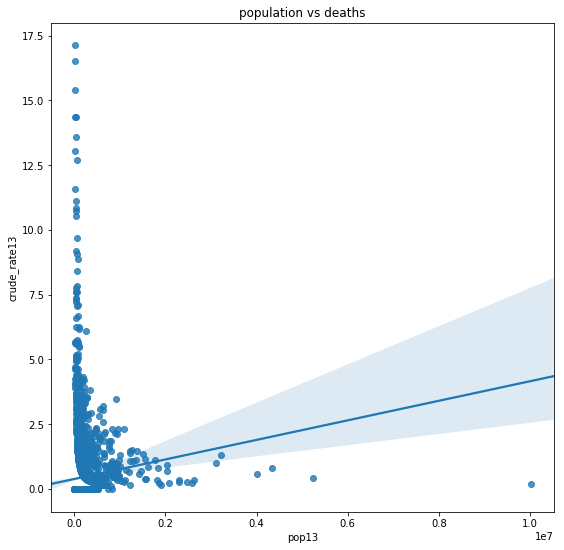

In [290]:
f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(x='pop13', y='crude_rate13', data=hdf)
plt.title('population vs deaths')
plt.show()

In [291]:
counties = gpd.read_file('us-counties.json')
counties.columns = ['county_code', 'name', 'geometry']
counties.county_code = counties.county_code.apply(int)

In [292]:
print(len(hdf))
hdf = counties[['county_code', 'geometry']].merge(hdf, on = 'county_code', how = 'right')
len(hdf)

3108


3108

In [293]:
drop_codes = hdf[hdf.geometry.isna()].index
drop_deaths = hdf[hdf.geometry.isna()].total_deaths.sum()
drop_deaths17 = hdf[hdf.geometry.isna()].deaths17.sum()
drop_deaths16 = hdf[hdf.geometry.isna()].deaths16.sum()
drop_deaths15 = hdf[hdf.geometry.isna()].deaths15.sum()
drop_deaths14 = hdf[hdf.geometry.isna()].deaths14.sum()
drop_deaths13 = hdf[hdf.geometry.isna()].deaths13.sum()

In [294]:
hdf = hdf.drop(drop_codes)

In [295]:
hdf.to_file(drive = 'ESRI Shapefile', filename = 'hdf.shp')

In [296]:
w = ps.queen_from_shapefile('hdf.shp')

/home/steve/anaconda3/lib/python3.7/site-packages/pysal/core/IOHandlers/pyShpIO.py:172: RuntimeWarning: SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)
  warn("SHAPEFILE WARNING: Polygon %d topology has been fixed. (ccw -> cw)" % (self.pos), RuntimeWarning)
/home/steve/anaconda3/lib/python3.7/site-packages/pysal/core/IOHandlers/pyShpIO.py:172: RuntimeWarning: SHAPEFILE WARNING: Polygon 2881 topology has been fixed. (ccw -> cw)
  warn("SHAPEFILE WARNING: Polygon %d topology has been fixed. (ccw -> cw)" % (self.pos), RuntimeWarning)


SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2881 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2881 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2881 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2881 topology has been fixed. (ccw -> cw)


In [297]:
# row standardization 
w.transform = 'r'

In [298]:
hdf['crude_rate_lag13'] = ps.lag_spatial(w, hdf['crude_rate13'])
hdf['crude_rate_lag14'] = ps.lag_spatial(w, hdf['crude_rate14'])
hdf['crude_rate_lag15'] = ps.lag_spatial(w, hdf['crude_rate15'])
hdf['crude_rate_lag16'] = ps.lag_spatial(w, hdf['crude_rate16'])
hdf['crude_rate_lag17'] = ps.lag_spatial(w, hdf['crude_rate17'])

In [299]:
rent_burden = pd.read_csv('ACS_17_5YR_B25070_with_ann.csv')
rent_burden = rent_burden[['GEO.id2', 'GEO.display-label', 'HD01_VD01', 'HD01_VD10']]
rent_burden.columns = ['county_code', 'county', 'total_renters', 'burden_over_50_percent']
rent_burden['percent_in_distress'] = rent_burden['burden_over_50_percent']/rent_burden['total_renters']
rent_burden = rent_burden[['county_code', 'percent_in_distress']]
hdf = hdf.merge(rent_burden, on = 'county_code', how = 'left')

In [300]:
prescriptions_17 = pd.read_csv('2017_opioid_prescriptions.csv')[['State/County FIPS Code', '2017']]
prescriptions_16 = pd.read_csv('2016_opioid_prescriptions.csv')[['FIPS County Code', '2016 Prescribing Rate']]
prescriptions_15 = pd.read_csv('2015_opioid_prescriptions.csv')[['FIPS County Code', '2015 Prescribing Rate']]
prescriptions_14 = pd.read_csv('2014_opioid_prescriptions.csv')[['FIPS County Code', '2014 Prescribing Rate']]
prescriptions_13 = pd.read_csv('2013_opioid_prescriptions.csv')[['FIPS County Code', '2013 Prescribing Rate']]
prescriptions_17.columns = ['county_code', 'prate_17']
prescriptions_16.columns = ['county_code', 'prate_16']
prescriptions_15.columns = ['county_code', 'prate_15']
prescriptions_14.columns = ['county_code', 'prate_14']
prescriptions_13.columns = ['county_code', 'prate_13']
hdf = hdf.merge(prescriptions_13, on = 'county_code', how = 'left')
hdf = hdf.merge(prescriptions_14, on = 'county_code', how = 'left')
hdf = hdf.merge(prescriptions_15, on = 'county_code', how = 'left')
hdf = hdf.merge(prescriptions_16, on = 'county_code', how = 'left')
hdf = hdf.merge(prescriptions_17, on = 'county_code', how = 'left')

In [301]:
# converting to floats, turning non numbers to Nan
def convert_prate(value):
    try:
        return float(value)
    except ValueError:
        return None
hdf['prate_17'] = hdf.prate_17.apply(convert_prate)
hdf['prate_16'] = hdf.prate_16.apply(convert_prate)
hdf['prate_15'] = hdf.prate_15.apply(convert_prate)
hdf['prate_14'] = hdf.prate_14.apply(convert_prate)
hdf['prate_13'] = hdf.prate_13.apply(convert_prate)

In [302]:
hdf[hdf.prate_13.isna() | hdf.prate_14.isna() | hdf.prate_15.isna() | hdf.prate_16.isna() | hdf.prate_17.isna()]

,county_code,geometry,county,state,deaths13,deaths14,deaths15,deaths16,deaths17,pop13,...,crude_rate_lag14,crude_rate_lag15,crude_rate_lag16,crude_rate_lag17,percent_in_distress,prate_13,prate_14,prate_15,prate_16,prate_17
52,1105,"POLYGON ((-87.326435 32.876127, -87.0197260000...","Perry County, AL",AL,0,0,0,0,0,10020,...,0.000000,0.000000,0.000000,0.000000,0.111702,NaN,5.2,4.0,3.6,3.6
72,4011,"POLYGON ((-109.497089 33.653852, -109.04798 33...","Greenlee County, AZ",AZ,0,0,0,0,0,9049,...,0.130772,0.263657,0.397551,0.801565,0.048369,NaN,1.3,0.5,0.0,0.0
94,5025,"POLYGON ((-92.058511 34.064623, -91.954449 34....","Cleveland County, AR",AR,0,0,0,0,0,8593,...,0.000000,0.000000,0.000000,0.000000,0.132009,NaN,0.4,0.6,1.1,0.7
118,5073,"POLYGON ((-93.723501 33.484067, -93.482516 33....","Lafayette County, AR",AR,0,0,0,0,0,7252,...,0.000000,0.000000,0.000000,0.000000,0.202806,NaN,4.2,1.7,111.2,111.0
131,5099,"POLYGON ((-93.45513099999999 33.955084, -93.37...","Nevada County, AR",AR,0,0,0,0,0,8799,...,0.000000,0.000000,0.000000,0.000000,0.071510,NaN,NaN,NaN,NaN,NaN
132,5101,"POLYGON ((-93.301777 36.123952, -92.945776 36....","Newton County, AR",AR,0,0,0,0,0,8064,...,0.000000,0.000000,0.000000,0.000000,0.087420,NaN,2.8,1.8,0.8,0.9
136,5109,"POLYGON ((-93.75088599999999 34.349424, -93.47...","Pike County, AR",AR,0,0,0,0,0,11177,...,0.000000,0.000000,0.000000,0.000000,0.142276,NaN,10.6,4.7,97.6,87.5
158,6003,"POLYGON ((-119.585614 38.714545, -119.640383 3...","Alpine County, CA",CA,0,0,0,0,0,1159,...,0.000000,0.000000,0.000000,0.000000,0.254902,NaN,NaN,NaN,NaN,NaN
225,8021,"POLYGON ((-106.523111 37.400079, -106.04114 37...","Conejos County, CO",CO,0,0,0,0,0,8277,...,1.257008,0.000000,2.081252,2.553691,0.137195,NaN,2.2,1.3,1.2,0.8
226,8023,"POLYGON ((-105.23603 37.624634, -105.153876 37...","Costilla County, CO",CO,0,0,0,0,0,3518,...,0.000000,0.000000,0.000000,0.000000,0.187082,NaN,NaN,NaN,NaN,NaN


In [303]:
# def convert_to_na(row, column):
#     if row[column] > 0:
#         return row[column]
#     elif row.total_deaths == 0:
#         return None
#     else:
#         return row[column]
# hdf.deaths13 = hdf.apply(lambda x: convert_to_na(x, 'deaths13'), axis = 'columns')
# hdf.deaths14 = hdf.apply(lambda x: convert_to_na(x, 'deaths14'), axis = 'columns')
# hdf.deaths15 = hdf.apply(lambda x: convert_to_na(x, 'deaths15'), axis = 'columns')
# hdf.deaths16 = hdf.apply(lambda x: convert_to_na(x, 'deaths16'), axis = 'columns')
# hdf.deaths17 = hdf.apply(lambda x: convert_to_na(x, 'deaths17'), axis = 'columns')
# hdf.total_deaths = hdf.apply(lambda x: convert_to_na(x, 'total_deaths'), axis = 'columns')

In [304]:
# try mixing together years vs one year at a time, try different independent variables
ground = hdf[hdf.total_deaths > 0].copy()
suppressed = hdf[hdf.total_deaths == 0].copy()
model = xgb.XGBRegressor(n_estimators = 200)
ind_var = ground[['state', 'deaths13', 'deaths14',
       'deaths15', 'deaths16', 'pop13', 'pop14', 'pop15', 'pop16',
       'pop17', 'total_deaths', 'crude_rate13', 'crude_rate14',
       'crude_rate15', 'crude_rate16', 'crude_rate_lag13',
       'crude_rate_lag14', 'crude_rate_lag15', 'crude_rate_lag16',
       'crude_rate_lag17', 'percent_in_distress', 'prate_13', 'prate_14',
       'prate_15', 'prate_16', 'prate_17']]
labels = ground['deaths17']
le = LabelEncoder()
le.fit(hdf.state)
ind_var['state'] = le.transform(ind_var['state'])
X_train, X_test, Y_train, Y_test = train_test_split(ind_var, labels, test_size = 0.2)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(Y_test, y_pred))
suppressed['state'] = le.transform(suppressed['state'])
suppressed_pred = model.predict(suppressed[['state', 'deaths13', 'deaths14',
       'deaths15', 'deaths16', 'pop13', 'pop14', 'pop15', 'pop16',
       'pop17', 'total_deaths', 'crude_rate13', 'crude_rate14',
       'crude_rate15', 'crude_rate16', 'crude_rate_lag13',
       'crude_rate_lag14', 'crude_rate_lag15', 'crude_rate_lag16',
       'crude_rate_lag17', 'percent_in_distress', 'prate_13', 'prate_14',
       'prate_15', 'prate_16', 'prate_17']])
print('Predicted deaths in 2017 in suppressed counties: ', sum(suppressed_pred))
print('Total deaths in 2017 in suppressed counties: ', national_fent[national_fent.year == 2017].deaths.values[0] - hdf.deaths17.sum())

/home/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/steve/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


70.90916083973221
Predicted deaths in 2017 in suppressed counties:  15810.101811885834
Total deaths in 2017 in suppressed counties:  1800


In [305]:
# try mixing together years vs one year at a time, try different independent variables
ground = hdf[hdf.total_deaths > 0].copy()
suppressed = hdf[hdf.total_deaths == 0].copy()
model = xgb.XGBRegressor(n_estimators = 200)
ind_var = ground[['state', 'deaths13', 'pop13', 'crude_rate13', 'crude_rate_lag13',
      'percent_in_distress', 'prate_13']]
labels = ground['deaths13']
le = LabelEncoder()
le.fit(hdf.state)
ind_var['state'] = le.transform(ind_var['state'])
X_train, X_test, Y_train, Y_test = train_test_split(ind_var, labels, test_size = 0.2)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(Y_test, y_pred))
suppressed['state'] = le.transform(suppressed['state'])
suppressed_pred = model.predict(suppressed[['state', 'deaths13', 'pop13', 'crude_rate13', 'crude_rate_lag13',
      'percent_in_distress', 'prate_13']])
print('Predicted deaths in 2013 in suppressed counties: ', sum(suppressed_pred))
print('Total deaths in 2013 in suppressed counties: ', national_fent[national_fent.year == 2013].deaths.values[0] - hdf.deaths13.sum())

0.005517052171653323
Predicted deaths in 2013 in suppressed counties:  0.17398416996002197
Total deaths in 2013 in suppressed counties:  567


/home/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/steve/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [306]:
# try training the model on all the data, including suppressed counties
model = xgb.XGBRegressor()
ind_var = hdf[['state', 'deaths13', 'deaths14',
       'deaths15', 'deaths16', 'pop13', 'pop14', 'pop15', 'pop16',
       'pop17', 'crude_rate13', 'crude_rate14',
       'crude_rate15', 'crude_rate16', 'crude_rate_lag13',
       'crude_rate_lag14', 'crude_rate_lag15', 'crude_rate_lag16',
       'crude_rate_lag17', 'percent_in_distress', 'prate_13', 'prate_14',
       'prate_15', 'prate_16', 'prate_17']]
labels = hdf['deaths17']
le = LabelEncoder()
le.fit(hdf.state)
ind_var['state'] = le.transform(ind_var['state'])
X_train, X_test, Y_train, Y_test = train_test_split(ind_var, labels, test_size = 0.2)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
mean_squared_error(Y_test, y_pred)

/home/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/steve/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


155.4579796943117

In [307]:
all_pred = model.predict(ind_var)

In [308]:
hdf['xgb_predicted'] = all_pred

In [309]:
hdf[(hdf.total_deaths == 0) & (hdf.xgb_predicted > 1)]

,county_code,geometry,county,state,deaths13,deaths14,deaths15,deaths16,deaths17,pop13,...,crude_rate_lag15,crude_rate_lag16,crude_rate_lag17,percent_in_distress,prate_13,prate_14,prate_15,prate_16,prate_17,xgb_predicted
40,1081,"POLYGON ((-85.184951 32.74468, -85.130182 32.7...","Lee County, AL",AL,0,0,0,0,0,150933,...,0.166186,0.168789,0.601195,0.303918,74.9,70.0,63.2,64.5,58.5,1.546288
50,1101,"POLYGON ((-86.30772399999999 32.416064, -86.02...","Montgomery County, AL",AL,0,0,0,0,0,226659,...,0.000000,0.000000,0.000000,0.287582,112.0,101.7,87.0,88.0,81.2,1.566605
81,4027,"POLYGON ((-113.993657 33.462159, -113.336425 3...","Yuma County, AZ",AZ,0,0,0,0,0,201201,...,0.686219,0.991818,2.008157,0.209541,57.9,57.6,58.0,56.6,48.5,1.837589
160,6007,"POLYGON ((-121.584697 40.100211, -121.436819 4...","Butte County, CA",CA,0,0,0,0,0,222090,...,0.000000,0.000000,0.000000,0.320782,157.3,143.9,136.9,125.4,106.7,1.566605
165,6017,"POLYGON ((-120.001861 39.065069, -119.903276 3...","El Dorado County, CA",CA,0,0,0,0,0,181737,...,0.026643,0.211296,0.130666,0.223847,80.2,75.6,68.8,63.7,55.7,1.570062
169,6025,"POLYGON ((-114.733044 33.434775, -114.628982 3...","Imperial County, CA",CA,0,0,0,0,0,176584,...,0.472587,0.499468,1.026724,0.258138,59.1,59.5,53.7,52.4,47.6,1.535386
176,6039,"POLYGON ((-119.267951 37.73965, -119.021489 37...","Madera County, CA",CA,0,0,0,0,0,152389,...,0.272095,0.555890,0.235086,0.233813,61.9,58.4,52.6,49.7,42.6,1.570062
177,6041,"POLYGON ((-122.844393 38.27639, -122.488392 38...","Marin County, CA",CA,0,0,0,0,0,258365,...,0.995726,1.192677,1.586618,0.261039,48.3,44.1,39.4,36.7,32.4,1.813814
183,6053,"POLYGON ((-121.699712 36.918109, -121.644943 3...","Monterey County, CA",CA,0,0,0,0,0,428826,...,0.557056,0.616344,0.733983,0.242097,62.9,60.3,55.6,50.6,43.9,2.276350
187,6061,"POLYGON ((-120.149738 39.317009, -120.007338 3...","Placer County, CA",CA,0,0,0,0,0,367309,...,0.128533,0.435180,0.733009,0.243671,76.3,72.9,66.5,62.9,56.5,2.276350


In [310]:
hdf[(hdf.total_deaths == 0) & (hdf.xgb_predicted > 0)][['deaths17', 'total_deaths', 'xgb_predicted']].xgb_predicted.sum()

210.85812

In [311]:
model = SVR()
nona_hdf = hdf.dropna()
ind_var = nona_hdf[['state', 'deaths13', 'deaths14',
       'deaths15', 'deaths16', 'pop13', 'pop14', 'pop15', 'pop16',
       'pop17', 'crude_rate13', 'crude_rate14',
       'crude_rate15', 'crude_rate16', 'crude_rate_lag13',
       'crude_rate_lag14', 'crude_rate_lag15', 'crude_rate_lag16',
       'crude_rate_lag17', 'percent_in_distress', 'prate_13', 'prate_14',
       'prate_15', 'prate_16', 'prate_17']]
labels = nona_hdf['deaths17']
le = LabelEncoder()
le.fit(hdf.state)
ind_var['state'] = le.transform(ind_var['state'])
X_train, X_test, Y_train, Y_test = train_test_split(ind_var, labels, test_size = 0.2)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
mean_squared_error(Y_test, y_pred)

/home/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/steve/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1311.5810715408027

In [312]:
def interpolate_suppressed(row):
    if row.total_deaths > 0:
        return row.deaths17
    elif row.xgb_predicted <= 0:
        return 0
    else:
        pred_value = round(row.xgb_predicted * 15)
        if pred_value > 9:
            pred_value = 9
        return pred_value
hdf['test_17'] = hdf.apply(interpolate_suppressed, axis = 'columns')

In [313]:
hdf[(hdf.test_17 > 0) & (hdf.total_deaths == 0 )][['test_17', 'total_deaths', 'xgb_predicted']]

,test_17,total_deaths,xgb_predicted
7,4,0,0.270282
21,2,0,0.115938
40,9,0,1.546288
47,2,0,0.115938
50,9,0,1.566605
60,2,0,0.115938
81,9,0,1.837589
144,4,0,0.270282
160,9,0,1.566605
165,9,0,1.570062


In [314]:
print(hdf.test_17.sum())
national_fent

28035


,year,deaths,population,crude_rate,aa_rate
0,1999.0,730,279040168.0,0.3,0.3
1,2000.0,782,281421906.0,0.3,0.3
2,2001.0,957,284968955.0,0.3,0.3
3,2002.0,1295,287625193.0,0.5,0.4
4,2003.0,1400,290107933.0,0.5,0.5
5,2004.0,1664,292805298.0,0.6,0.6
6,2005.0,1742,295516599.0,0.6,0.6
7,2006.0,2707,298379912.0,0.9,0.9
8,2007.0,2213,301231207.0,0.7,0.7
9,2008.0,2306,304093966.0,0.8,0.8


In [315]:
hdf[hdf.state == 'AL'].test_17.sum()

178

In [316]:
for state in hdf.state.unique():
    print(state, fent_by_state[(fent_by_state.year == 2017) & (fent_by_state.state_abbr == state)].deaths.values[0] - hdf[hdf.state == state].test_17.sum())

AL 20
AZ -1
AR 33
CA -89
CO 11
CT 0
DE 0
DC 0
FL 10
GA 94
ID 1
IL 41
IN -32
IA 31
KS 4
KY -70
LA -15
ME -13
MD -8
MA 4
MI 27
MN 26
MS 43
MO 46
MT -9
NE -5
NV 5
NH 0
NJ -8
NM 14
NY 32
NC -44
ND 2
OH -41
OK 53
OR 14
PA -49
RI 13
SC 7
SD 12
TN 50
TX -2
UT 16
VT -6
VA 106
WA 12
WV -17
WI 46
WY 17


In [320]:
hdf[(hdf.deaths17 > 0) & (hdf.total_deaths == 0)]

,county_code,geometry,county,state,deaths13,deaths14,deaths15,deaths16,deaths17,pop13,...,crude_rate_lag16,crude_rate_lag17,percent_in_distress,prate_13,prate_14,prate_15,prate_16,prate_17,xgb_predicted,test_17


In [321]:
hdf.to_csv('interpolated_dataframe.csv')